### Imports

In [1]:

import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
import re
import matplotlib.ticker as ticker
from matplotlib import patheffects

### Read packets processed by the switch and the number of packets sent to the NIDS

In [2]:
def read_sw_info(filepath):
    try:
        with open(filepath) as file:
            protocol_dict = {"\\x01": "ICMP", "\\x06": "TCP", "\\x11": "UDP"}

            previous_line = ""
            protocol = ""
            get_cloned_data, get_processed_data = False, False
            get_cloned_packets = False

            packets_processed, packets_cloned = 0, 0
            packets_cloned_by_protocol = {}

            for line in file:
                if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 2" in line:
                    get_cloned_data = True

                if "packet_count" in line and get_cloned_data == True:
                    packets_cloned = int(line.split()[1])
                    get_cloned_data = False

                if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 3" in line:
                    get_processed_data = True

                if "packet_count" in line and get_processed_data == True:
                    packets_processed = int(line.split()[1])
                    get_processed_data = False

                if "MyIngress.ipv4_nids meta.protocol" in line:
                    protocol = protocol_dict[re.search('protocol b\'(.+?)\'', line).group(1)]
                    get_cloned_packets = True

                if "packet_count" in line and get_cloned_packets == True:
                    if protocol in packets_cloned_by_protocol:
                        packets_cloned_by_protocol[protocol]+=int(line.split()[1])
                    else:
                        packets_cloned_by_protocol[protocol]=int(line.split()[1])
                    get_cloned_packets = False

                previous_line = line
    except Exception as e:
        print(e)
    return packets_cloned, packets_processed, packets_cloned_by_protocol


### Read amount of alerts

In [3]:
def read_alerts_info(filepath):
    num_lines = 0
    protocol_count = {}
    with open(filepath) as file:
        for line in file:
            num_lines+=1
            try:
                proto = re.search('proto\" : \"(.+?)\",', line).group(1)
                if proto in protocol_count:
                    protocol_count[proto]+=1
                else:
                    protocol_count[proto]=1
                
            except AttributeError as e:
                print(e)
        
    return num_lines, protocol_count

### Read number of processed packets by Snort

In [4]:
def read_Snort_info(filepath):
    packets_received_Snort= 0 
    with open(filepath) as csvfile:
        csv_file = pd.read_csv(csvfile)
        packets_received_Snort = csv_file["daq.received"].sum()

    return packets_received_Snort     

### Read the folder containing all experiments

In [5]:
input_folder = "/home/ubuntu/p4-ddos/brum-p4/results/rules_analysis"

data = []
for scenario in os.listdir(input_folder):
    if os.path.isfile(os.path.join(input_folder, scenario)):
        continue

    for experiment_round in os.listdir(os.path.join(input_folder, scenario)):
        
        if "1" not in experiment_round: # Read only one round of each pcap
            continue

        exp = experiment_round.split("_")
        abs_path = os.path.join(input_folder, scenario, experiment_round)

        packets_cloned, packets_processed, packets_cloned_by_protocol= read_sw_info(os.path.join(abs_path, "stdout_output.txt"))
        num_alerts, protocol_count = read_alerts_info(os.path.join(abs_path, "eth0/alert_json.txt"))
        packets_received_Snort = read_Snort_info(os.path.join(abs_path, "eth0/perf_monitor_base.csv"))
        
        data.append([scenario, exp[0], packets_cloned, packets_cloned_by_protocol, packets_received_Snort, num_alerts, protocol_count])
    
complete_df = pd.DataFrame(data, columns=["scenario","pcap","packets cloned", "packets cloned protocol count", "packets received by snort","alerts", "alerts protocol count"])

complete_df["scenario"] = complete_df.scenario.str.replace("_", " ")

scenario_order = {"reduced ruleset no flag":0, "reduced ruleset zeroed flags":1, "all rules original flags": 2, "all rules no flags":3}
complete_df.sort_values(by=['scenario'], inplace=True, key=lambda x: x.map(scenario_order))
display(complete_df)

,scenario,pcap,packets cloned,packets cloned protocol count,packets received by snort,alerts,alerts protocol count
19,reduced ruleset no flag,Tuesday,11469696,"{'ICMP': 444, 'TCP': 10710230, 'UDP': 759022}",10719200,101466,"{'UDP': 65074, 'TCP': 36050, 'ICMP': 342}"
17,reduced ruleset no flag,Friday,9915501,"{'ICMP': 965, 'TCP': 9191727, 'UDP': 722809}",9815583,88897,"{'UDP': 81502, 'TCP': 6345, 'ICMP': 1050}"
16,reduced ruleset no flag,Thursday,9240593,"{'ICMP': 1429, 'TCP': 8538148, 'UDP': 701016}",8916798,100871,"{'UDP': 78083, 'TCP': 20829, 'ICMP': 1959}"
15,reduced ruleset no flag,Monday,11626439,"{'ICMP': 671, 'TCP': 10718469, 'UDP': 907299}",10721537,82772,"{'UDP': 74149, 'TCP': 8058, 'ICMP': 565}"
18,reduced ruleset no flag,Wednesday,13705535,"{'ICMP': 366, 'TCP': 12943316, 'UDP': 761853}",13420763,559502,"{'UDP': 83741, 'TCP': 475264, 'ICMP': 497}"
0,reduced ruleset zeroed flags,Monday,907970,"{'ICMP': 671, 'UDP': 907299}",871149,75255,"{'UDP': 74690, 'ICMP': 565}"
4,reduced ruleset zeroed flags,Tuesday,759466,"{'ICMP': 444, 'UDP': 759022}",723639,65575,"{'UDP': 65233, 'ICMP': 342}"
3,reduced ruleset zeroed flags,Wednesday,762219,"{'ICMP': 366, 'UDP': 761853}",657606,83786,"{'UDP': 83289, 'ICMP': 497}"
2,reduced ruleset zeroed flags,Friday,723774,"{'ICMP': 965, 'UDP': 722809}",685533,82794,"{'UDP': 81744, 'ICMP': 1050}"
1,reduced ruleset zeroed flags,Thursday,702791,"{'ICMP': 1429, 'TCP': 346, 'UDP': 701016}",666500,80188,"{'UDP': 78229, 'ICMP': 1959}"


### Clean and organize dataframe

In [6]:
temp_df = complete_df["alerts protocol count"].apply(pd.Series).fillna(0).astype(int)
temp_df = temp_df.reindex(sorted(temp_df.columns), axis=1)
alerts_df = pd.concat([complete_df.drop(["alerts protocol count"], axis=1), temp_df], axis=1)
alerts_df = alerts_df[["scenario", "pcap", "ICMP", "TCP", "UDP"]]
display(alerts_df)

temp_df = complete_df["packets cloned protocol count"].apply(pd.Series).fillna(0).astype(int)
temp_df = temp_df.reindex(sorted(temp_df.columns), axis=1)
packets_protocol_df = pd.concat([complete_df.drop(["packets cloned protocol count"], axis=1), temp_df], axis=1)
packets_protocol_df = packets_protocol_df[["scenario", "pcap", "ICMP", "TCP", "UDP"]]
display(packets_protocol_df)

packets_df = complete_df[["scenario", "pcap", "packets cloned", "packets received by snort"]]
display(packets_df)

,scenario,pcap,ICMP,TCP,UDP
19,reduced ruleset no flag,Tuesday,342,36050,65074
17,reduced ruleset no flag,Friday,1050,6345,81502
16,reduced ruleset no flag,Thursday,1959,20829,78083
15,reduced ruleset no flag,Monday,565,8058,74149
18,reduced ruleset no flag,Wednesday,497,475264,83741
0,reduced ruleset zeroed flags,Monday,565,0,74690
4,reduced ruleset zeroed flags,Tuesday,342,0,65233
3,reduced ruleset zeroed flags,Wednesday,497,0,83289
2,reduced ruleset zeroed flags,Friday,1050,0,81744
1,reduced ruleset zeroed flags,Thursday,1959,0,78229


,scenario,pcap,ICMP,TCP,UDP
19,reduced ruleset no flag,Tuesday,444,10710230,759022
17,reduced ruleset no flag,Friday,965,9191727,722809
16,reduced ruleset no flag,Thursday,1429,8538148,701016
15,reduced ruleset no flag,Monday,671,10718469,907299
18,reduced ruleset no flag,Wednesday,366,12943316,761853
0,reduced ruleset zeroed flags,Monday,671,0,907299
4,reduced ruleset zeroed flags,Tuesday,444,0,759022
3,reduced ruleset zeroed flags,Wednesday,366,0,761853
2,reduced ruleset zeroed flags,Friday,965,0,722809
1,reduced ruleset zeroed flags,Thursday,1429,346,701016


,scenario,pcap,packets cloned,packets received by snort
19,reduced ruleset no flag,Tuesday,11469696,10719200
17,reduced ruleset no flag,Friday,9915501,9815583
16,reduced ruleset no flag,Thursday,9240593,8916798
15,reduced ruleset no flag,Monday,11626439,10721537
18,reduced ruleset no flag,Wednesday,13705535,13420763
0,reduced ruleset zeroed flags,Monday,907970,871149
4,reduced ruleset zeroed flags,Tuesday,759466,723639
3,reduced ruleset zeroed flags,Wednesday,762219,657606
2,reduced ruleset zeroed flags,Friday,723774,685533
1,reduced ruleset zeroed flags,Thursday,702791,666500


### Function to add labels in a bar plot

In [14]:

# Add a label on top of each bar plot
def add_value_labels(ax, stroke_width=0, decimal_format=0, spacing=8, y_spacing=0):
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
     
        # Use Y value as label and format number with one decimal place
        str_ = "{:."+str(decimal_format)+"f}"
        if (y_value == 0):
            continue
        label = str_.format(y_value)
        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(y_spacing, spacing),          # Vertically shift label by `spacing`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va='bottom',                      # Vertically align label for positive values ('bottom' for positive, 'top' for negatives).
            color=rect.get_facecolor(),
            weight='bold',
            path_effects=[patheffects.withStroke(linewidth=stroke_width, foreground="black")]
            )    

### Plot the protocol count of each alert

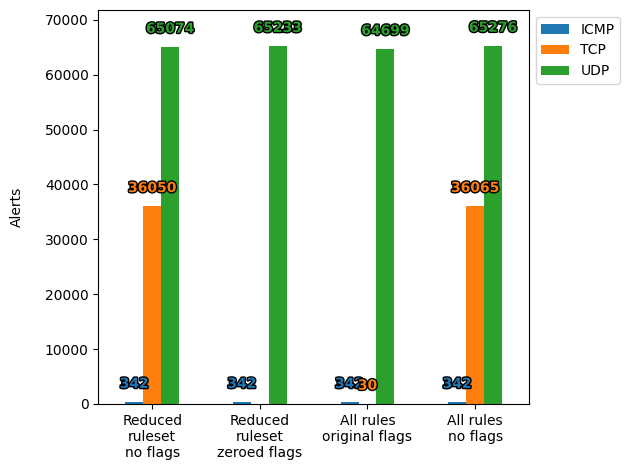

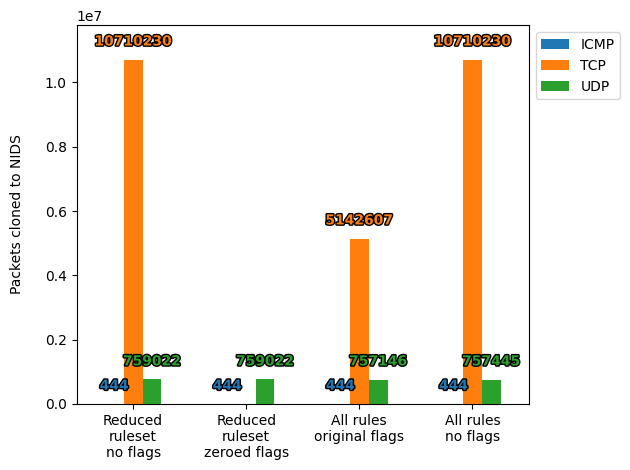

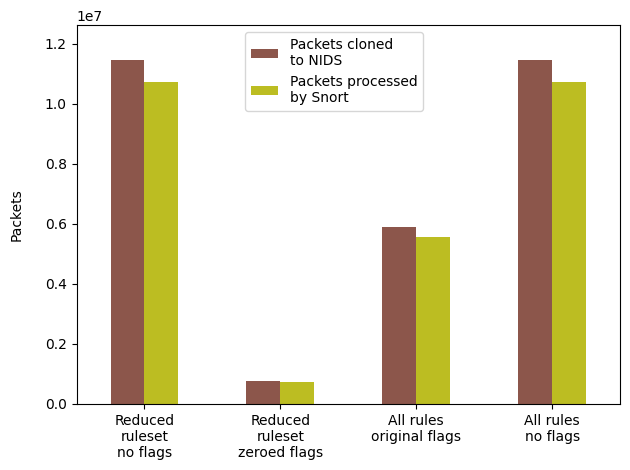

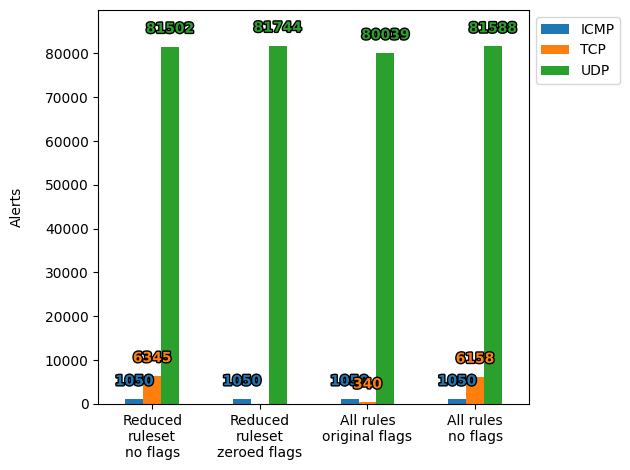

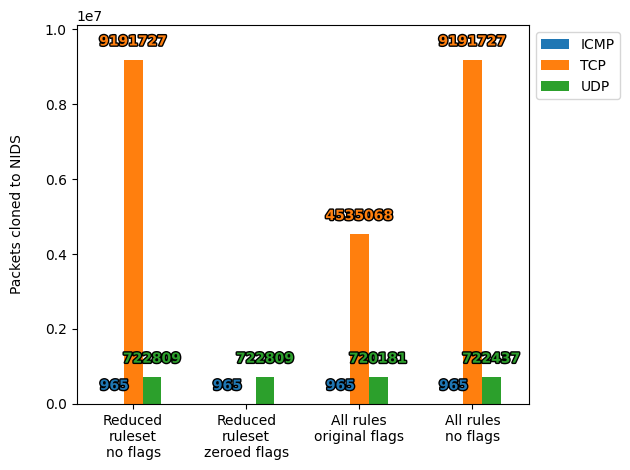

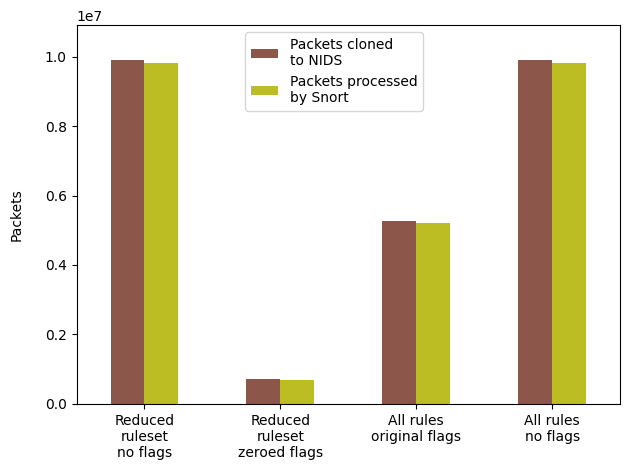

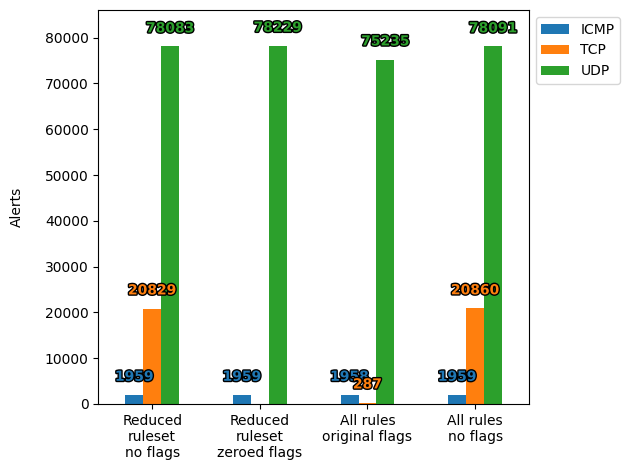

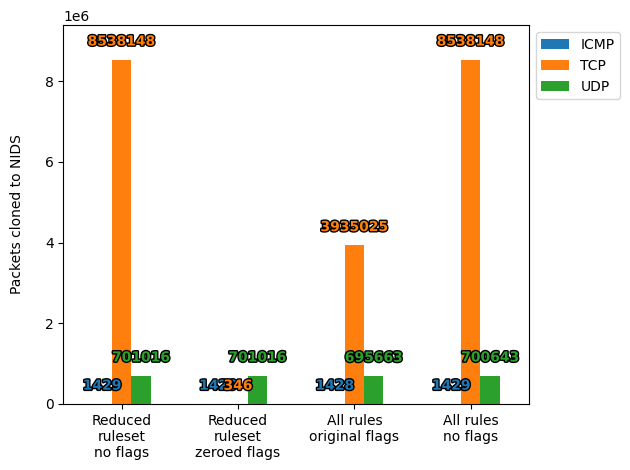

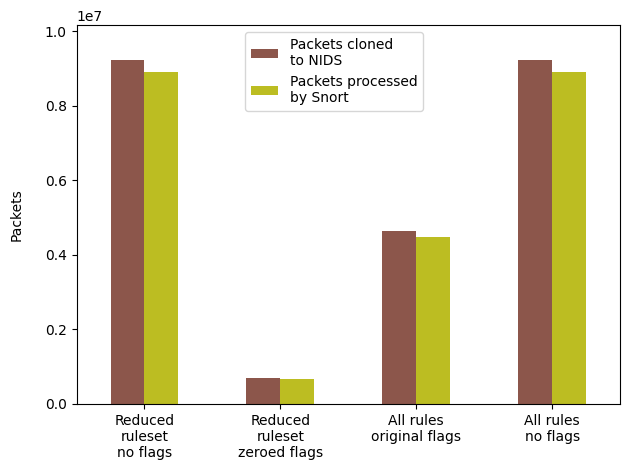

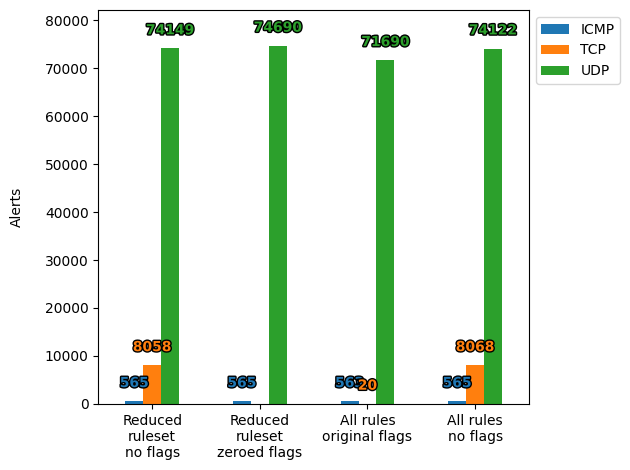

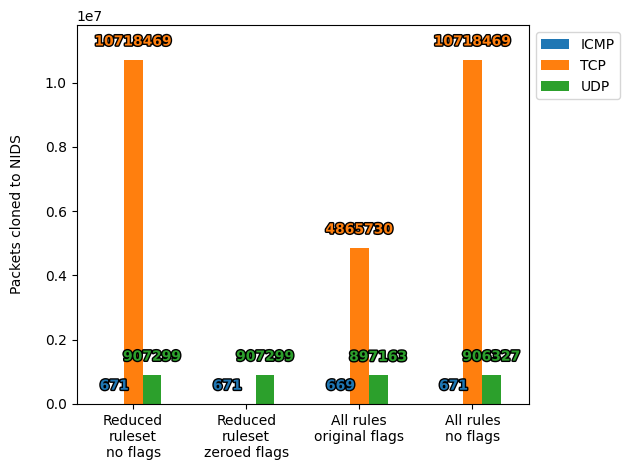

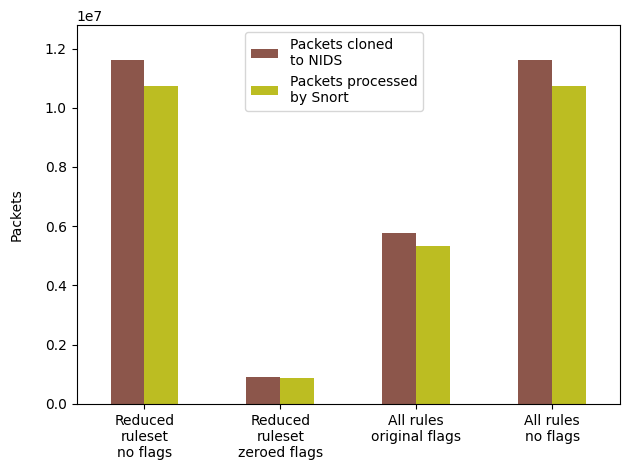

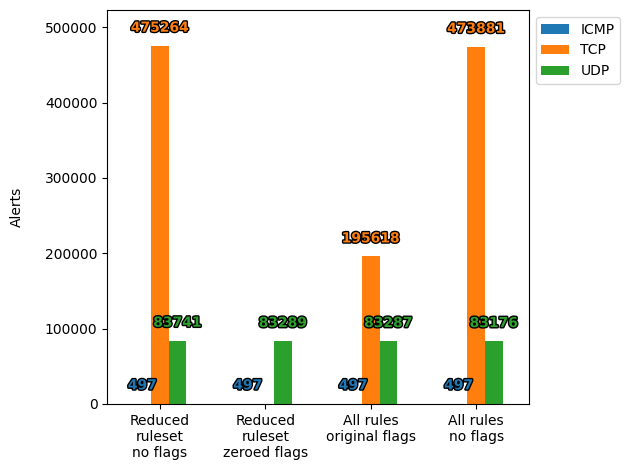

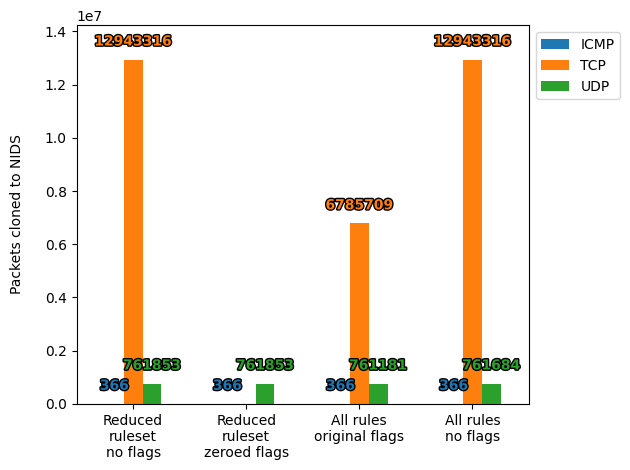

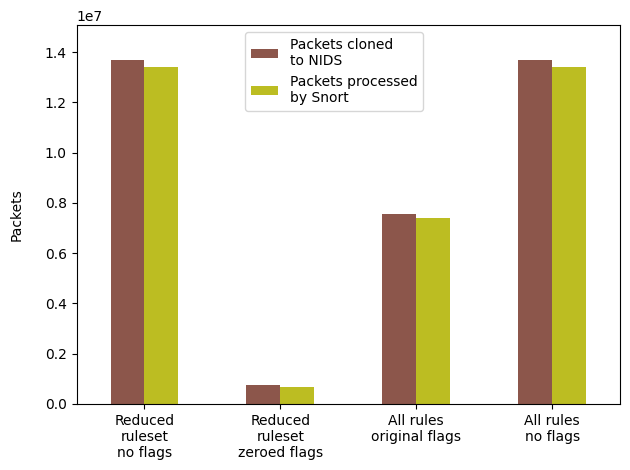

In [18]:
def plot(df, ylabel, legend_labels, filename, add_bar_label=True, stacked=False, color=['#1f77b4', '#ff7f0e', '#2ca02c'], bbox=(1,1)):
    df.set_index('scenario', inplace=True)
    ax = df.plot(kind='bar', stacked=stacked, rot=0, color=color)
    ax.margins(y=0.1)
    if(add_bar_label):
        add_value_labels(ax, stroke_width=2)

    plt.xlabel(xlabel=None)
    labels = ["Reduced\nruleset\nno flags", "Reduced\nruleset\nzeroed flags",  "All rules\noriginal flags","All rules\nno flags"]
    plt.xticks([i for i in range(len(labels))], labels)
    plt.legend(labels=legend_labels, bbox_to_anchor=bbox)
    plt.ylabel(ylabel, labelpad=15)
    plt.tight_layout()
    plt.savefig(filename)

for pcap in alerts_df["pcap"].unique():
    filename = "rules_graphs/alerts_by_protocol_"+pcap+".png"
    legend_labels = ["ICMP", "TCP", "UDP"]
    plot(alerts_df[alerts_df["pcap"] == pcap], "Alerts", legend_labels, filename)

    filename = "rules_graphs/packets_to_NIDS_by_protocol_"+pcap+".png"
    legend_labels = ["ICMP", "TCP", "UDP"]
    plot(packets_protocol_df[packets_protocol_df["pcap"] == pcap], "Packets cloned to NIDS", legend_labels, filename)

    filename = "rules_graphs/packets_to_NIDS_"+pcap+".png"
    legend_labels = ["Packets cloned\nto NIDS", "Packets processed\nby Snort"]
    plot(packets_df[packets_df["pcap"] == pcap], "Packets", legend_labels, filename, add_bar_label=False, color=['#8c564b', '#bcbd22'], bbox=(0.65,1))
